# Самостоятельная работа № 1

### Задание 1

Модуль лингвистической предобработки текста является одним из важнейших компонентов современных TTS систем.
Стандартный набор преобразований над текстом включает в себя:
- нормализацию 
- токенизацию 
- построение транскрипции

Нормализация подразумевает расшифровку числовых последовательностей, дат, оббревиатур, иноязычных вставок, сокращений и т.д. (не путать с приведением к нормальной форме слов - принятой терминологиией в NLP).

Токенизация - разбиение текста на предложения и слова.

Построение транскрипции позволяет получить из графемного фонемное представление текста. На этом же этапе разрешается пробелма расстановки ударений. 

Предлагается построить простой пайплайн лингвистической предобработки: токенизация на предложения, нормализация каждого предложения, получение фонемной последовательности для каждого предложения.

### Инструкция по установке и подключению сторонних библиотек из репозиторией (если не устанавливается через pip)
1. Склонировать репозиторий 

*!git clone путь к репозиторию*

2. Добавить корень репо в PATH

*sys.path.append("корень склонированного репо")*

3. Установить необходимые зависимости для репо

*!pip install название библиотеки*

In [ ]:
# утрановка необходимых библиотек

!pip install -q google-colab

In [ ]:
# Импорт необходимых библиотек

import numpy as np
import os
import sys
import uuid
import torch
import librosa

from google.colab import drive
from google.colab import files
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
# ваш номер
my_id = uuid.uuid4().hex
print(my_id)

da800ea4d813411b94b9d3cd401adde1


In [ ]:
if not os.path.exists("razdel"):
  !git clone https://github.com/natasha/razdel.git

sys.path.append("razdel")
from razdel import tokenize

In [ ]:
# Исходный текст
input_text = "В 1785 г в городе Augsburg случилось странное проишествие. Группа в 18 человек, где каждый весил не менее 100 кг, устроила праздник на втором этаже деревянного здания."

In [ ]:
# Используйте razdel отсюда https://github.com/natasha/razdel

def tokenize_by_sent(text):
  "Возвращает список токенизированных предложений"
  return " ".join(token.text for token in tokenize(text))

In [ ]:
sentences = tokenize_by_sent(input_text)

In [ ]:
print(sentences)

В 1785 г в городе Augsburg случилось странное проишествие . Группа в 18 человек , где каждый весил не менее 100 кг , устроила праздник на втором этаже деревянного здания .


Токенизация на предложения нужна и при подготовке обучающих баз и при инференсе системы. Обучать модель на длинных текстах как правило не целесообразно. 

Токенизация на слова может понадобится для получения границ слов, получения знаков препринания, может требоваться для более качественной нормализации.

In [ ]:
if not os.path.exists("russian_stt_text_normalization"):
  !git clone https://github.com/snakers4/russian_stt_text_normalization.git

sys.path.append("russian_stt_text_normalization")
from normalizer import Normalizer

In [ ]:
# Для реализации функции воспользуйтесь инструментом Normalizer из этого
# репозитория https://github.com/snakers4/russian_stt_text_normalization
# подсказка по путям sys.path.append("russian_stt_text_normalization")

def normalize(text):
  "Возвращает нормализованное предложение"
  normalizer = Normalizer(jit_model="russian_stt_text_normalization/jit_s2s.pt")
  return " ".join(normalizer.norm_text(token) for token in text.split(" "))

In [ ]:
#norm_sentences = [normalize(sentence) for sentence in sentences]
norm_sentences = normalize(sentences)

100%|██████████| 1/1 [00:00<00:00, 360.18it/s]


In [ ]:
print(norm_sentences)

В тысяча семьсот восемьдесят пятый г в городе огсберг случилось странное проишествие . Группа в восемнадцать человек , где каждый весил не менее сто кг , устроила праздник на втором этаже деревянного здания .


In [ ]:
! rm -rf "russian_g2p" "root_russian_g2p"
if not os.path.exists("russian_g2p"):
  !pip install dawg
  !git clone https://github.com/nsu-ai/russian_g2p.git
  os.rename("russian_g2p", "root_russian_g2p")
  os.replace("root_russian_g2p/russian_g2p", "russian_g2p")

sys.path.append("russian_g2p")
from russian_g2p.Accentor import Accentor

Cloning into 'russian_g2p'...
remote: Enumerating objects: 878, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 878 (delta 6), reused 9 (delta 4), pack-reused 854
Receiving objects: 100% (878/878), 33.92 MiB | 16.08 MiB/s, done.
Resolving deltas: 100% (586/586), done.


Нормализация текста - сложная задача. Далеко не всегда открытые решения хорошо с ней справляются. Нормализация на основе лингвистических баз и правил может справляться с задачей лучше, чем нейросетевая модель.

In [ ]:
# Для реализации используйте Accentor отсюда https://github.com/nsu-ai/russian_g2p
# Для решения проблем с импортом в этой библиотеке лучше перенести папку russian_g2p ближе к корню
# os.rename("russian_g2p", "root_russian_g2p")
# os.replace("root_russian_g2p/russian_g2p", "russian_g2p")


def g2p(text):
  "Возвращает список из фонем входящего текста"
  accentor = Accentor()
  return [accentor.do_accents([[token]])[0] for token in text.split()]

In [ ]:
#phonemes_sequences = [g2p(sentence) for sentence in norm_sentences]
phonemes_sequences = g2p(norm_sentences)

/content/russian_g2p/Accentor.py:559: UserWarning: Word `огсберг` is unknown!
  warnings.warn(err_msg)
/content/russian_g2p/Accentor.py:559: UserWarning: Word `проишествие` is unknown!
  warnings.warn(err_msg)


In [ ]:
print(phonemes_sequences)

[['в'], ['ты+сяча'], ['семьсо+т'], ['во+семьдесят'], ['пя+тый'], ['г'], ['в'], ['го+роде'], ['огсберг'], ['случи+лось'], ['стра+нное'], ['проишествие'], ['.'], ['гру+ппа'], ['в'], ['восемна+дцать'], ['челове+к'], [','], ['где+'], ['ка+ждый'], ['ве+сил'], ['не'], ['ме+нее'], ['сто+'], ['кг'], [','], ['устро+ила'], ['пра+здник'], ['на'], ['второ+м'], ['этаже+'], ['деревя+нного'], ['зда+ния'], ['.']]


In [ ]:
# Сохраняем результат себе

with open(f"result_1_{my_id}.txt", 'w') as f_out:
  for sequence in phonemes_sequences:
    f_out.write(f'{" ".join(sequence)}\n')

In [ ]:
files.download(f"result_1_{my_id}.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Насколько можно видеть, итоговая последовательность может представлять из себя простой список из фонем, к котором не видно границ слов или знаков препинания.
В самом просто варианте, границы слов можно обозначить пробельным символом. Однако знаки препинания лучше исключить из финальной последовательности, т.к. их наличие будет мешать модели выстраивать матрицу внимания (какой длительности будет многоточие или знак вопроса?). 

### Задание 2

Пайплайн получения признаков из аудио для TTS может быть достаточно сложным.
Последовательность обработчиков и их параметры будут зависеть в том числе и от особенностей вокодера. 
Наиболее распространенным вариантом акустических признаков является логарифмированная мел-спектрограмма.

Задание - реализовать функции построения мел-спектрограммы с заданными параметрами.

Общий вид пайплайна такой: Входной сигнал -> Pre-emphasis -> STFT -> Магнитуда-> Мел-скейл -> Логарифмирование

In [ ]:
# примонтировать свой диск (куда заранее положили нужный wav файл)
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# загрузки входного сигнала (скорее всего путь будет таким 'gdrive/MyDrive/audio_sample/example.wav') 
# можно воспользоваться librosa

def read_wave(wave_path):
  "возвращает волну и sample rate"
  return librosa.load(wave_path, sr=None)

wave_path = "gdrive/MyDrive/audio_sample/example.wav"
wave, sr = read_wave(wave_path)

In [ ]:
print(f"Sample rate = {sr}")
print(f"Wave max = {np.max(wave)} Wave min {np.min(wave)}")

Sample rate = 22050
Wave max = 0.4473876953125 Wave min -0.579498291015625


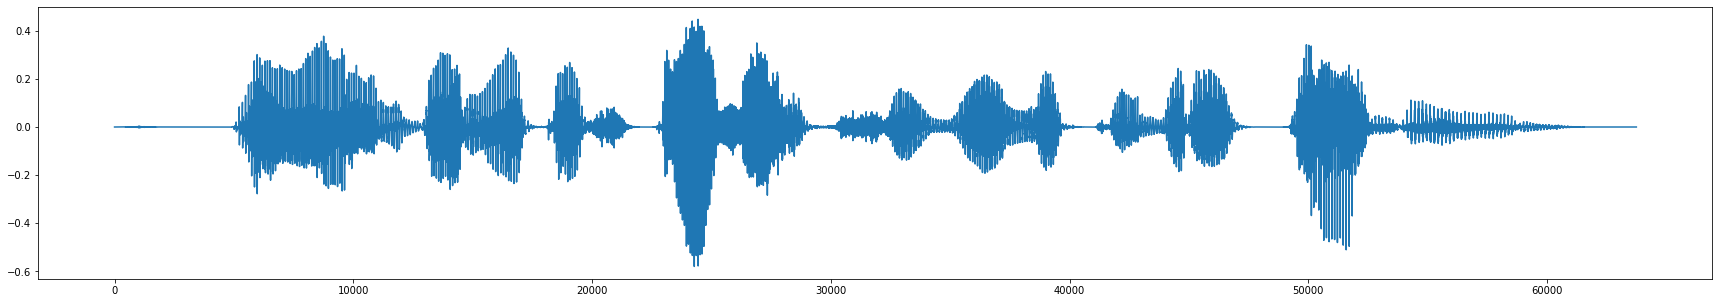

In [ ]:
plt.figure(figsize=(30, 5))
plt.plot(wave)

Данные могут быть в формате float32 или int16 (обычно ...). Нужно привести к формату float32 в диапазоне значений [0, 1]. Стоит обратить внимание на максимальное и минимальное значение (если значения близки к максимум и минимуму диапазона, возможно они были нормализованы или даже клипированы). 

In [ ]:
# Pre-emphasis
# y_t = x_t − α * x_t − 1
# α = 0.97

def preemphasis(x, coef=0.85):
  return np.append(x[0], x[1:] - coef * x[:-1])

preemh_wave = preemphasis(wave, 0.97)

In [ ]:
preemh_librosa = librosa.effects.preemphasis(wave, 0.97)

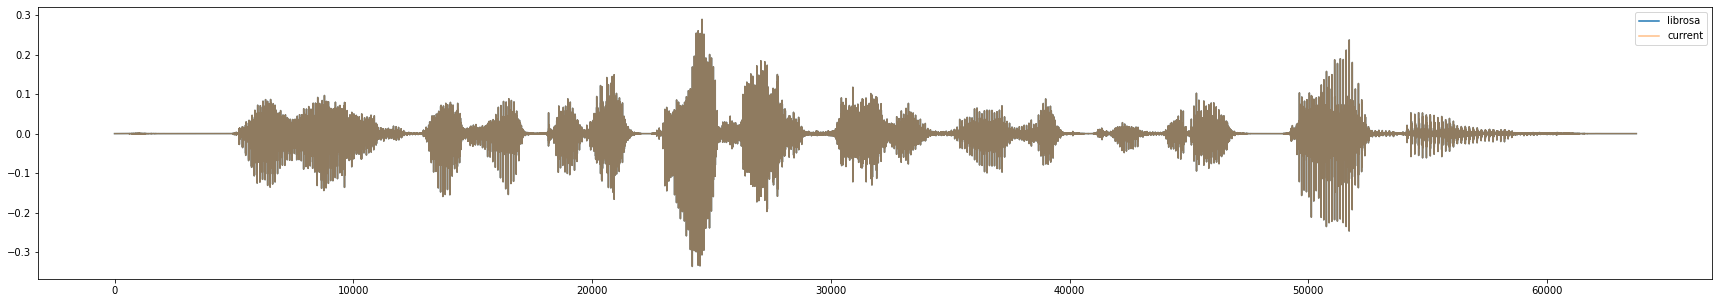

In [ ]:
plt.figure(figsize=(30, 5))
plt.plot(preemh_librosa, label="librosa")
plt.plot(preemh_wave, label="current", alpha=0.5)
plt.legend()
plt.show()

Обратимое преобразование. Усиливает высокие частоты, ослабляет низкие. 

В вокодерах необходим для уменьшения высокочастотного шума при мю-кодировании.


In [ ]:
# STFT (можно воспользоваться librosa)
# window = 1024, hop = 256, паддинг reflect, центрировать не надо, окно Ханна


def get_stft(data, n_fft, hop, window):
  return librosa.stft(data,
                      n_fft=n_fft,
                      hop_length=hop,
                      win_length=n_fft,
                      window=window,
                      center=False,
                      pad_mode="reflect")

stft_features = get_stft(preemh_wave, 1024, 256, 'hann')
stft_features_raw = get_stft(wave, 1024, 256, 'hann')

Short-time Fourier transform. Комплексные значения признаков. 

Окно анализа обычно соразмерно средней длине фонемы, шаг близким к средней длине коротких фонем (эвристические соображения от которых стоит отталкиваться).

In [ ]:
# Магнитуда
# получить амплитудный спектр

def get_magnitude(features):
  return np.abs(features)

magnitude_features = get_magnitude(stft_features)
magnitude_features_raw = get_magnitude(stft_features_raw)

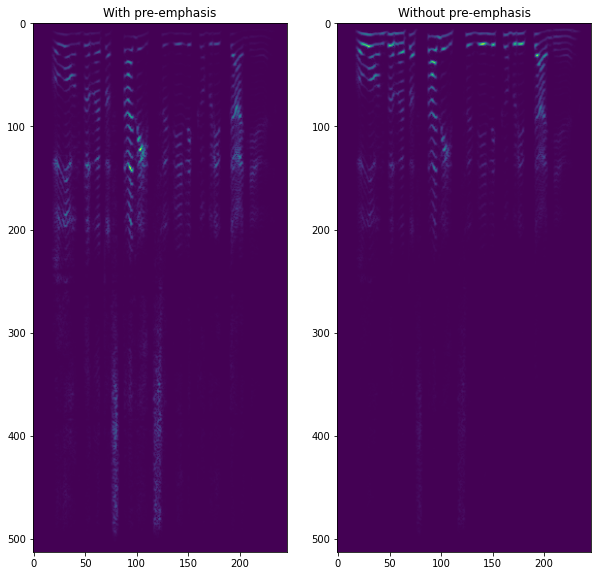

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(magnitude_features)
plt.title("With pre-emphasis")

plt.subplot(1, 2, 2)
plt.imshow(magnitude_features_raw)
plt.title("Without pre-emphasis")

plt.show()

Теряется информация о фазе (фазовые признаки значительно менее структурированы). Признаки все еще довольно большого размера. В некоторых моделях TTS применяются и такие.

In [ ]:
# Мел-скейл. Реализуется в матричном виде как X_mel = Mel_basis * X, где Mel_basis 
# 100 бинов без ограничений частот (можно воспользоваться librosa.filters)

def get_mel_features(magnitude_features, mel_basis):
  return mel_basis.dot(magnitude_features)

def get_mel_basis(sample_rate, size):
  return librosa.filters.mel(sr=sample_rate, n_fft=1024, n_mels=size)

mel_basis = get_mel_basis(sr, 100)
mel_features = get_mel_features(magnitude_features, mel_basis)
mel_features_raw = get_mel_features(magnitude_features_raw, mel_basis)


In [ ]:
print(f"max {mel_features.max()} min {mel_features.min()} mean {mel_features.mean()}")

max 0.34877118468284607 min 0.0 mean 0.008609442040324211


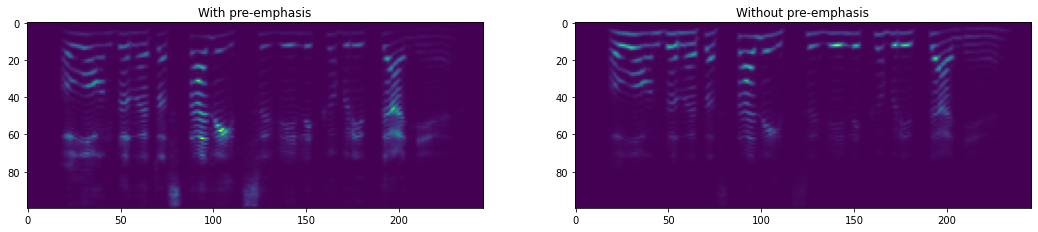

In [ ]:
plt.figure(figsize=(18, 18))

plt.subplot(1, 2, 1)
plt.imshow(mel_features)
plt.title("With pre-emphasis")

plt.subplot(1, 2, 2)
plt.imshow(mel_features_raw)
plt.title("Without pre-emphasis")

plt.show()

Значительно уменьшается размер признаков, при этом практически не теряется воспринимаемое акустическое качество.

In [ ]:
# Логарифмирование
# амплитуды лучше логарифмировать ln(x), 
# 1e-5 установить минимальным значением под логарифмом (для вычислительной стабильности)
# 20log10(x) был бы перевод в децибелы, но разница в константе, поэтому можно не усложнять

def get_log_features(features):
  #return np.log(np.clip(features, 1e-5, None))
  return np.log1p(features)

log_mel_features = get_log_features(mel_features)
log_mel_features_raw = get_log_features(mel_features_raw)


In [ ]:
print(f"max {log_mel_features.max()} min {log_mel_features.min()} mean {log_mel_features.mean()}")

max 0.29919394850730896 min 0.0 mean 0.00837565865367651


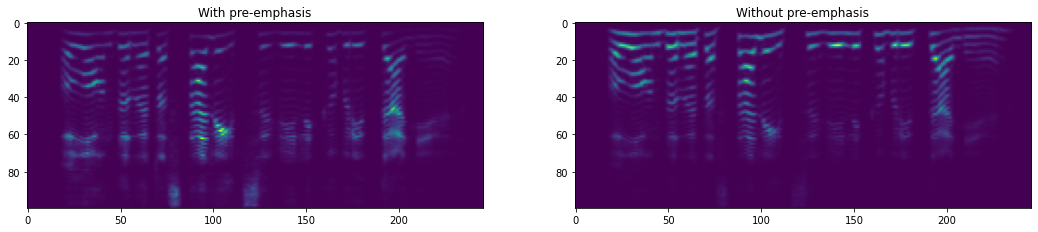

In [ ]:
plt.figure(figsize=(18, 18))

plt.subplot(1, 2, 1)
plt.imshow(log_mel_features)
plt.title("With pre-emphasis")

plt.subplot(1, 2, 2)
plt.imshow(log_mel_features_raw)
plt.title("Without pre-emphasis")

plt.show()

Такие признаки уже можно нормализовать.

Совет - посмотрите, как будет выглядеть эти же признаки без pre-emphasis.

In [ ]:
# Выгрузим результат
np.save(f"log_mel_features_{my_id}.npy", log_mel_features)
files.download(f"log_mel_features_{my_id}.npy") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Задание 3

Механизм внимания позволяет модели отображать последовательность фонем на спектрограмму. Базовый вариант, предложенный в модели Tacotron 1, называется content based attention.

Этот простой механизм пришел в TTS из области машинного перевода и он не учитывает многих особенностей синтеза речи. В главном это монотонный и локальный характер внимания. 

Монотонность обеспечивается тем, что порядок звуков и фонем одинаковый (если одна фонема находится в порядке после другой, то и ее признаки в спектрограмме будут находится после признаков первой, в отличие от задачи машинного перевода, где порядок слов в разных языках может отличаться). 

Локальность обеспечивается тем, что фонемы влияют на звучание только своих ближайших соседей.

Не очень подходящий механзм внимания значительно влияет на качество и естественность речи. Непрерывные длинные участки речи с ним вообще крайне затруднительно синтезировать (внимание "ломается", "рассыпается", пропадают звуки, слова, речь заедает, звучит "белиберда", ломается голос, интонации).

Разработано уже много вариантов улучшения механизма внимания. А одни из лучших способов - сразу прогнозировать длительность фонем.

Попробуем на игрушечном примере построить один из рабочих вариантов механизма внимания FORWARD ATTENTION (https://arxiv.org/pdf/1807.06736.pdf). 

In [ ]:
import torch
import numpy as np

In [ ]:
seq_len = 100
enc_size = 32
attn_rnn_size = 16
dec_rnn_size = 16
attn_inner_size = 32
decoder_steps = 200 # у нас нет остановки, поэтому зададим заранее количество шагов декодера

In [ ]:
# загрузим заранее сгенерированный вектор
encoder_output = torch.from_numpy(np.load("gdrive/MyDrive/audio_sample/encoder_output.npy"))

In [ ]:
class Attention(torch.nn.Module):
  def __init__(self, query_size, key_size, attn_inner_size):
    super(Attention, self).__init__()
    self.softmax = torch.nn.Softmax(dim=0)
    self.query = torch.nn.Linear(query_size, attn_inner_size, bias=False)
    self.key = torch.nn.Linear(key_size, attn_inner_size, bias=False)
    self.v = torch.nn.Linear(attn_inner_size, 1, bias=False)

  def forward(self, queries, keys):
    keys = self.key(keys)
    queries = self.query(queries)
    attn = self.v(torch.tanh((queries + keys)).squeeze())
    attn = self.softmax(attn)
    return attn


class SimpleAttnDecoder(torch.nn.Module):
  def __init__(self, enc_size, attn_rnn_size, dec_rnn_size, attn_inner_size):
    super(SimpleAttnDecoder, self).__init__()
    self.attn_rnn_size = attn_rnn_size
    self.dec_rnn_size = dec_rnn_size
    self.enc_size = enc_size
    self.attention = Attention(attn_rnn_size, enc_size, attn_inner_size)
    self.rnn_attn = torch.nn.RNNCell(input_size=enc_size, hidden_size=attn_rnn_size)
    self.rnn_decoder = torch.nn.RNNCell(input_size=enc_size, hidden_size=dec_rnn_size)

  def forward(self, encoder_output, output_len):
    attention_matrix = []
    outputs = []
    attention_state = torch.zeros(1, self.attn_rnn_size).float()
    decoder_state = torch.zeros(1, self.dec_rnn_size).float()
    context = torch.zeros(1, self.enc_size).float()
    
    forward_probs = torch.zeros(1, seq_len).float()
    forward_probs[0][0] = 1


    verbose = 200
    for idx in range(output_len):
      attention_state = self.rnn_attn(context, attention_state)
      attention_probs = self.attention(attention_state, encoder_output)

      # forward attention - это всего-лишь модификация attention_probs 
      # допишите класс SimpleAttnDecoder, чтобы в этом месте срабатывал forward attention 
      # Algorithm 1 из предложенной статьи без transition agent
      # . . . тут вставка forward attention

      forward_probs = torch.cat((
            forward_probs[:,:1].flatten(),
            (forward_probs[:,1:] + forward_probs[:,:-1]).flatten()
          ), dim=0).unsqueeze(0)

      forward_probs *= attention_probs.flatten()
      forward_probs /= forward_probs.sum()


      context = torch.matmul(forward_probs, encoder_output.squeeze())
      
      # context = torch.mm(encoder_output.squeeze().transpose(0,1), attention_probs).transpose(0,1)

      decoder_state = self.rnn_decoder(context, decoder_state)
      
      attention_matrix.append(forward_probs.transpose(0,1))
      outputs.append(decoder_state)
    
    attention_matrix = torch.stack(attention_matrix).transpose(0,1).squeeze()
    outputs = torch.stack(outputs).transpose(0,1).squeeze()
    return outputs, attention_matrix

In [ ]:
decoder = SimpleAttnDecoder(enc_size, attn_rnn_size, dec_rnn_size, attn_inner_size)
decoder.load_state_dict(torch.load("gdrive/MyDrive/audio_sample/decoder_state_dict.pt"))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  outputs, attention_matrix = decoder(encoder_output, decoder_steps)

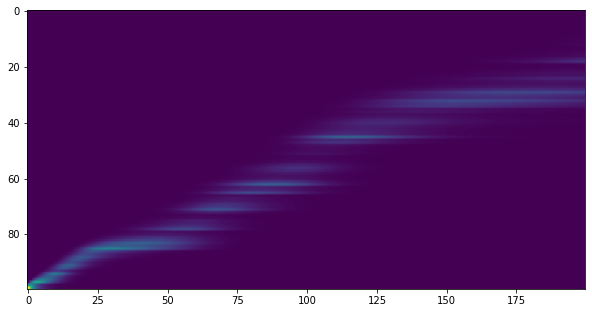

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(attention_matrix.flip(0))

In [ ]:
# Выгрузим готовый результат (матрицу внимания с реализованным forward attention)
np.save(f"attention_{my_id}.npy", attention_matrix.flip(0).numpy())
files.download(f"attention_{my_id}.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Матрица внимания будет значительно диагональнее (и это модель со случайным входом и случайными весами!)